# CAUSAL INFERENCE

## IMPORTS

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## GLOSSARY

$T_i$ the treatment for unit $i$:

$
T_i =
\begin{cases} 
1 & \text{if unit } i \text{ received the treatment} \\
0 & \text{otherwise}
\end{cases}
$

Treatment is  a term  to denote some intervention for which we want to know the effect of. In this case, the treatment is simply a price drop for one of the businesses inside your online platform, represented by the column `is_on_sale`.

$
T \leftarrow f_t(u_t)
$

this equation, saying that $u_t$, a set of variables we are not explicitly modeling (also called exogenous variables), causes the treatment $T$ via the function $f_t$

$
Y \leftarrow f_y(T, u_y)
$
T alongside another set of variables uy (which I’m also
choosing not to model) jointly causes the outcome Y via the function fy. uy is
in this last equation to say that the outcome is not determined by the
treatment alone.

## Conversion

In [3]:
df= pd.read_csv('./datasets/cross_sell_email.csv')

df.head()

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


In [6]:
# To estimate causal effect of different type email distribution among customers we can compute the average conversion for each treatment group
(df.groupby(['cross_sell_email']).mean())

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


**INTERIM CONCLUSION**

You can see that the group assigned to no
email had a conversion rate of 4.2%, while the groups assigned to the
long and short email had a conversion rate of 5.5% and a whopping
12.5%, respectively.

In [11]:
# Check the normalized differences between the treatment group
X= ['gender', 'age']

mu= df.groupby('cross_sell_email')[X].mean()
var= df.groupby('cross_sell_email')[X].var()

norm_diff= ((mu - mu.loc['no_email']) /
            np.sqrt((var + var.loc['no_email']) /2 ))

print(norm_diff)

                    gender       age
cross_sell_email                    
long              0.015802  0.221423
no_email          0.000000  0.000000
short             0.184341  0.087370


## Moivre's eq. (SE Standadrd Error)

$SE = \frac{\sigma}{\sqrt{n}}$

In [12]:
df= pd.read_csv('./datasets/enem_scores.csv')

In [13]:
df.sort_values(by='avg_score', ascending=False)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
...,...,...,...,...
3208,2006,22062661,125,23.51
459,2006,13006614,217,23.22
473,2007,13008196,145,21.79
472,2006,13008196,133,18.44


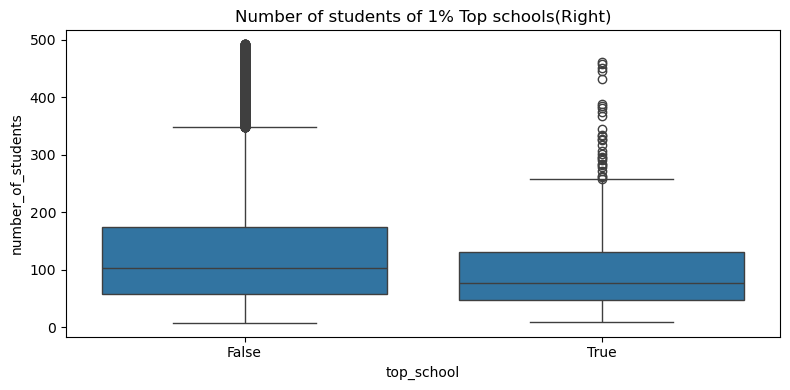

In [23]:
# Calculate quantiles
quantile_score = np.quantile(df['avg_score'], 0.99)
quantile_students = np.quantile(df['number_of_students'], 0.98)

# Filter data and assign top_school flag
plot_data = (df
             .assign(top_school=df['avg_score'] >= quantile_score) # Creates a new column it is True for rows where the avg_score is greater than or equal to the 99th percentile (top 1%) of the avg_score distribution.
             .loc[:, ['top_school', 'number_of_students']] #  only the columns top_school and number_of_students are kept in the resulting DataFrame.
             .query('number_of_students < @quantile_students')) # Filters the df to include only rows where number_of_students is less than the 98th percentile (top 2% excluded) of number_of_students.


plt.figure(figsize=(8,4))
ax= sns.boxplot(x='top_school', y='number_of_students', data=plot_data)
plt.title('Number of students of 1% Top schools(Right)')
plt.tight_layout()
plt.show()

In [24]:
quantile_score

71.15

Text(0.5, 1.0, 'ENEM Score by Number of Student in the School')

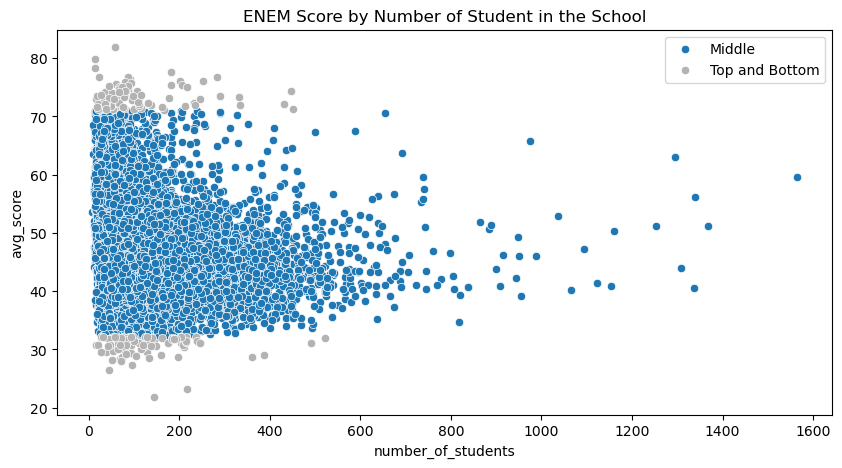

In [29]:
q_99= np.quantile(df['avg_score'], .99)
q_01= np.quantile(df['avg_score'], .01)

plot_data= (df
            .sample(10000)
            .assign(Group= lambda d: np.select([(d['avg_score'] > q_99) | (d['avg_score'] < q_01)],['Top and Bottom'], 'Middle')))

plt.figure(figsize=(10,5))
sns.scatterplot(y='avg_score', x='number_of_students', data=plot_data.query("Group=='Middle'"), label='Middle')
ax= sns.scatterplot(y='avg_score', x='number_of_students', data=plot_data.query("Group !='Middle'"), color='0.7', label='Top and Bottom')

plt.title('ENEM Score by Number of Student in the School')

**INTERIM CONCLUSION**

What we observe is precisely what’s expected according to
Moivre’s equation. As the number of students grows, the average score
becomes more and more precise. Schools with very few students (low
sample size) can have very high and low scores simply due to chance.
This is less likely to occur in large schools. 
Estimate of the school performance has a
huge variance when the sample size is small. It also indicates that
variance shrinks as the sample size increases.